In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Loading the datasets

tele = pd.read_csv("/content/drive/MyDrive/EV_Energy_Consumption_Dataset.csv")
trip = pd.read_csv("/content/drive/MyDrive/Electric Vehicle Trip Energy Consumption Data.csv")

In [21]:
# Removing duplicates
tele = tele.drop_duplicates()
trip = trip.drop_duplicates()

In [22]:
# Handling missing values
# Numeric → fill with median
num_cols_df1 = tele.select_dtypes(include=['float64', 'int64']).columns
num_cols_df2 = trip.select_dtypes(include=['float64', 'int64']).columns

tele[num_cols_df1] = tele[num_cols_df1].fillna(tele[num_cols_df1].median())
trip[num_cols_df2] = trip[num_cols_df2].fillna(trip[num_cols_df2].median())

In [23]:
# Categorical → fill with mode
cat_cols_df1 = tele.select_dtypes(include=['object']).columns
cat_cols_df2 = trip.select_dtypes(include=['object']).columns

# Only fill if there are categorical columns
if not cat_cols_df1.empty:
    for col in cat_cols_df1:
        tele[col] = tele[col].fillna(tele[col].mode()[0])

if not cat_cols_df2.empty:
    for col in cat_cols_df2:
        trip[col] = trip[col].fillna(trip[col].mode()[0])

In [24]:
# 3. Convert Timestamp to datetime (dataset 1)
if 'Timestamp' in tele.columns:
    tele['Timestamp'] = pd.to_datetime(tele['Timestamp'], errors='coerce')
    tele['Timestamp'] = tele['Timestamp'].fillna(tele['Timestamp'].mode()[0])

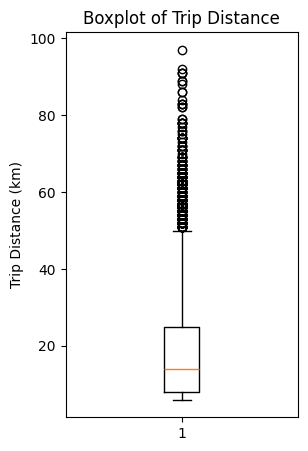

In [25]:
# 4. Boxplot for Trip Distance
plt.figure(figsize=(3,5))
plt.boxplot(trip['Trip Distance'].dropna())
plt.title('Boxplot of Trip Distance')
plt.ylabel('Trip Distance (km)')
plt.show()

In [26]:
# OUTLIER REMOVAL (IQR)
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

In [27]:
# Apply to important numeric columns
cols_to_check_tele = ['Speed_kmh', 'Acceleration_ms2', 'Battery_State_%']
cols_to_check_trip = ['Trip Distance', 'Trip Energy Consumption', 'Trip Time Length']

for col in cols_to_check_tele:
    if col in tele.columns:
        tele = remove_outliers_iqr(tele, col)

for col in cols_to_check_trip:
    if col in trip.columns:
        trip = remove_outliers_iqr(trip, col)

In [41]:
# LABEL ENCODING

label_enc = LabelEncoder()

categorical_cols_tele = ['Driving_Mode', 'Road_Type', 'Traffic_Condition']
categorical_cols_trip = ['Day of Week']

for col in categorical_cols_tele:
    if col in tele.columns:
        tele[col] = label_enc.fit_transform(tele[col])

for col in categorical_cols_trip:
    if col in trip.columns:
        trip[col] = label_enc.fit_transform(trip[col])

In [29]:
# SCALING NUMERIC FEATURES

scaler = StandardScaler()

tele[num_cols_df1] = scaler.fit_transform(tele[num_cols_df1])
trip[num_cols_df2] = scaler.fit_transform(trip[num_cols_df2])

In [30]:
print("Preprocessing Completed Successfully!")

Preprocessing Completed Successfully!


In [31]:
# TRAIN/TEST SPLIT
# To predict energy consumption

X = trip.drop(columns=['Trip Energy Consumption'])
y = trip['Trip Energy Consumption']

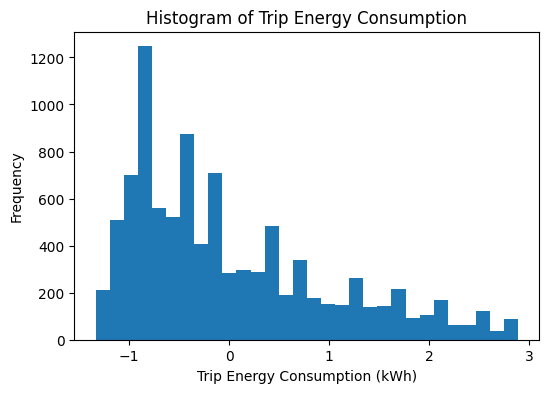

In [32]:
# 1. Histogram of target variable
plt.figure(figsize=(6,4))
plt.hist(trip['Trip Energy Consumption'].dropna(), bins=30)
plt.title('Histogram of Trip Energy Consumption')
plt.xlabel('Trip Energy Consumption (kWh)')
plt.ylabel('Frequency')
plt.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (7678, 12)
Testing shape: (1920, 12)


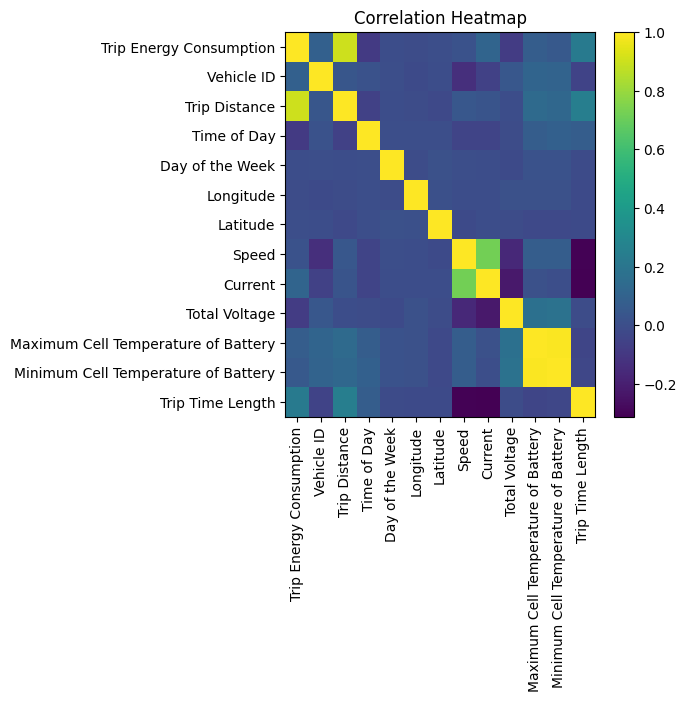

In [35]:
# Correlation heatmap

numeric_df = trip.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()

plt.figure(figsize=(5,5))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.title('Correlation Heatmap')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

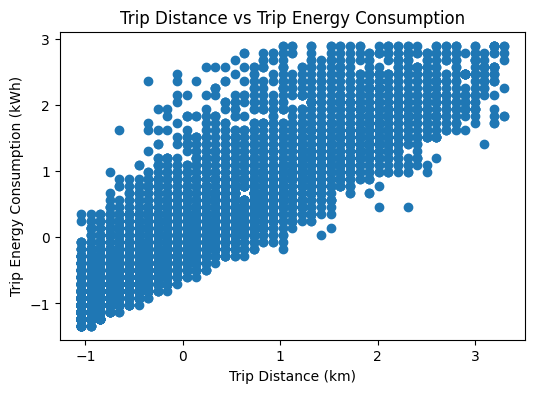

In [36]:
# Scatter plot: Trip Distance vs Trip Energy Consumption
plt.figure(figsize=(6,4))
plt.scatter(trip['Trip Distance'], trip['Trip Energy Consumption'])
plt.title('Trip Distance vs Trip Energy Consumption')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Trip Energy Consumption (kWh)')
plt.show()

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = lin_reg.predict(X_test)

# Evaluation
print("===== Linear Regression Results =====")
print("MAE :", mean_absolute_error(y_test, y_pred_lr))
print("MSE :", mean_squared_error(y_test, y_pred_lr))
print("R2 Score :", r2_score(y_test, y_pred_lr))

===== Linear Regression Results =====
MAE : 0.2862371338753239
MSE : 0.15951530313801499
R2 Score : 0.8434778420768421


In [38]:
# 2. Random Forest Regressor
rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)
rf_reg.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_reg.predict(X_test)

# Evaluation
print("\n===== Random Forest Regressor Results =====")
print("MAE :", mean_absolute_error(y_test, y_pred_rf))
print("MSE :", mean_squared_error(y_test, y_pred_rf))
print("R2 Score :", r2_score(y_test, y_pred_rf))



===== Random Forest Regressor Results =====
MAE : 0.2439290096222362
MSE : 0.1189931020888971
R2 Score : 0.8832396845285111


In [39]:
# Predict using Random Forest
unseen_predictions = rf_reg.predict(X_test)

# Show first 10 predictions
print("Sample Predictions on Unseen Test Data:")
print(unseen_predictions[:10])

# Compare with actual values
print("\nActual Values:")
print(y_test[:10].values)

Sample Predictions on Unseen Test Data:
[-1.00043236 -0.59155055 -0.89199669 -0.94224736 -0.69681249  0.67741124
  0.0109286  -0.66560417 -0.55769746  0.83662654]

Actual Values:
[-0.91421278 -0.59684009 -1.12579457 -0.70263099 -0.59684009  0.88423244
  0.56685976 -0.70263099 -0.70263099  1.7305596 ]


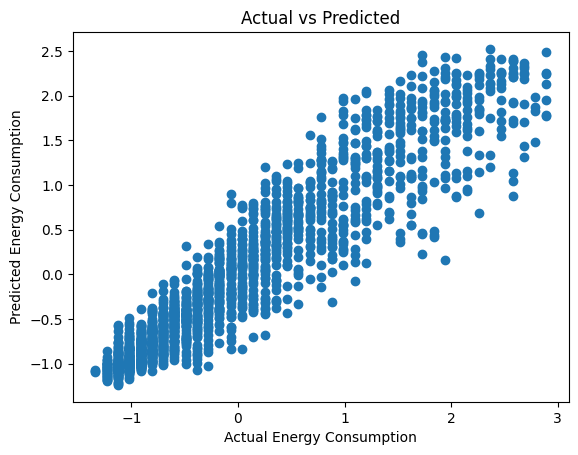

In [40]:
plt.scatter(y_test, unseen_predictions)
plt.xlabel("Actual Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.title("Actual vs Predicted")
plt.show()